In [1]:
import sys
sys.path.append('/cluster/sj1')

In [2]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
import numpy as np
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from bb_opt.src.bayesian_opt import (
    optimize,
    get_model_bnn,
    train_model_bnn,
    partial_train_model_bnn,
    train,
    bnn_predict
)
from bb_opt.src.utils import get_path, save_pyro_model, load_pyro_model
from gpu_utils.utils import gpu_init
from tqdm import tnrange

gpu_id = gpu_init()
print(f"Running on GPU {gpu_id}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

Running on GPU 1


In [3]:
def jointplot(predicted, true, title: str=""):
    if isinstance(predicted, torch.Tensor):
        predicted = predicted.detach().cpu().numpy()

    if isinstance(true, torch.Tensor):
        true = true.detach().cpu().numpy()
        
    ax = sns.jointplot(predicted, true, s=3, alpha=0.5)
    #ax = sns.regplot(predicted, true)
    ax.set_axis_labels('Predicted', 'True')
    ax.ax_marg_x.set_title(title)
    return ax

In [4]:
n_train = 1000

project = "dna_binding"
dataset = "crx_ref_r1"
batch_size = 1
retrain_every = 1000000
partial_steps = 20

root = "/cluster/sj1/bb_opt/"
data_dir = get_path(root, "data", project, dataset)
inputs = np.load(get_path(data_dir, "inputs.npy"))
labels = np.load(get_path(data_dir, "labels.npy"))
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, train_size=n_train, random_state=521)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, train_size=0.9, random_state=521)

top_k_percent = 1

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
train_label_mean = train_labels.mean()
train_label_std = train_labels.std()

train_labels = (train_labels - train_label_mean) / train_label_std
val_labels = (val_labels - train_label_mean) / train_label_std
test_labels = (test_labels - train_label_mean) / train_label_std

In [6]:
n_samples = 10
prior_mean = 0
prior_std = 1

bnn_model, guide = get_model_bnn(inputs.shape[1], batch_size, prior_mean, prior_std, device=device)
optimizer = pyro.optim.Adam({})

pyro.clear_param_store()

svi = pyro.infer.SVI(bnn_model, guide, optimizer, pyro.infer.Trace_ELBO(n_samples))

to_torch = lambda array: torch.tensor(array, dtype=torch.float32, device=device)
train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels = list(map(to_torch, [train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels]))

In [7]:
train_losses = []
val_losses = []

train_corrs = []
val_corrs = []

In [ ]:
model_path = "crx_100_starter_sid"

progress = tnrange(1000)
for i in progress:
    print(i)
    train_losses += train(svi, 5, train_inputs, train_labels, verbose=False)

    preds = bnn_predict(guide, train_inputs, n_samples=50).mean(axis=0)
    train_corrs.append(kendalltau(preds, train_labels)[0])

#     if n_inputs == 1:
#         mses.append((preds - train_labels.item()) ** 2)

    preds = bnn_predict(guide, val_inputs, n_samples=50).mean(axis=0)
    val_corr = kendalltau(preds, val_labels)[0]

    if val_corr > max(val_corrs, default=-float("inf")):
        save_pyro_model(model_path, optimizer)

    val_corrs.append(val_corr)
    progress.set_description(f"Corr: {val_corr:.3f}")


#     _, sorted_idx = train_labels.sort(descending=True)
#     n_10_percent = int(len(train_labels) * .1)

#     preds = bnn_predict(guide, train_inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
#     best_train_corrs.append(kendalltau(preds, train_labels[sorted_idx][:n_10_percent])[0])

#     _, sorted_idx = test_labels.sort(descending=True)
#     n_10_percent = int(len(test_labels) * .1)

#     preds = bnn_predict(guide, test_inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
#     best_test_corrs.append(kendalltau(preds, test_labels[sorted_idx][:n_10_percent])[0])

In [ ]:
#model, guide = bnn_model()
#model_dir = '/cluster/sj1/bb_opt/models'
model_dir = '.'
model_prefix = 'crx_100_starter'
pyro.get_param_store().load(model_dir + '/' + model_prefix + '.params')
optimizer = pyro.optim.Adam({})
optimizer.load(model_dir+'/'+model_prefix+'.opt')

In [ ]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(train_losses)
plt.title("Loss")

plt.subplot(122)
plt.plot(train_losses[-3000:])
plt.title("Recent Loss")

plt.figure(figsize=(15, 4))

# plt.subplot(121)
# plt.plot(mses)
# plt.title("MSE")

# plt.subplot(122)
plt.plot(train_corrs, label="train_corrs")
plt.plot(val_corrs, label="val_corrs")
plt.legend()
plt.title("Kendall Tau");
# plt.plot(pd.Series(losses[-3000:]).rolling(window=100).median());

title = "DNA Binding - CRX"
train_title = title + " (train)"
val_title = title + " (val)"

if n_train > 1:
    preds = bnn_predict(guide, train_inputs, n_samples=100).mean(axis=0)
    jointplot(preds, train_labels, train_title)

preds = bnn_predict(guide, val_inputs, n_samples=100).mean(axis=0)
jointplot(preds, val_labels, val_title);

In [ ]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(losses)
plt.title("Loss")

plt.subplot(122)
plt.plot(losses[-3000:])
plt.title("Recent Loss")

plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(mses)
plt.title("MSE")

plt.subplot(122)
plt.plot(train_corrs, label="train_corrs")
plt.plot(test_corrs, label="test_corrs")
plt.legend()
plt.title("Kendall Tau");
# plt.plot(pd.Series(losses[-3000:]).rolling(window=100).median());

title = "DNA Binding - CRX"
train_title = title + " (train)"
test_title = title + " (test)"

if n_inputs > 1:
    preds = bnn_predict(guide, train_inputs, n_samples=50).mean(axis=0)
    jointplot([preds], train_labels, train_title)

preds = bnn_predict(guide, test_inputs, n_samples=50).mean(axis=0)
jointplot(preds, test_labels, test_title);

In [ ]:
save_pyro_model(model_path, optimizer)

In [8]:
from bb_opt.src.hsic import *

In [9]:
bnn_model, guide = get_model_bnn(inputs.shape[1], batch_size, prior_mean, prior_std, device=device)
optimizer = pyro.optim.Adam({})
pyro.clear_param_store()

In [16]:
#load_pyro_model("../models/crx_1000", optimizer)
load_pyro_model("../models/crx_100_starter", optimizer)

In [17]:
preds = bnn_predict(guide, torch.tensor(inputs, device=device), 100)

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.3510855565447028


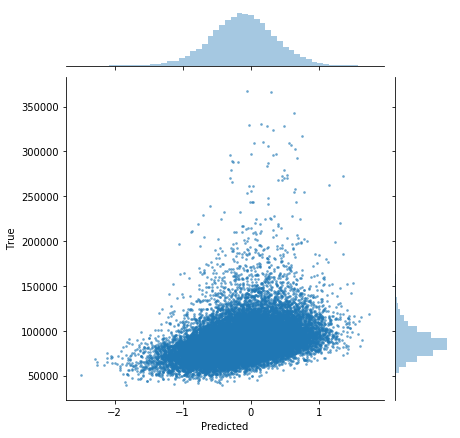

In [18]:
jointplot(preds.mean(axis=0), labels)
print(np.corrcoef(preds.mean(axis=0), labels)[0, 1])

In [19]:
inputs = torch.tensor(inputs, device=device)

In [36]:
n_preds = 1000
with torch.no_grad():
    preds = [torch.unsqueeze(guide()(inputs).squeeze(), 0) for _ in range(n_preds)]
preds = torch.cat(preds)

In [21]:
kernel = dimwise_mixrq_kernels

In [37]:
preds.shape

torch.Size([1000, 32896])

In [23]:
all_hsic = []
all_idx = list(range(len(inputs)))
n_points_parallel = 50

max_pred_idx = preds.argmax(dim=1)
max_dist = inputs[max_pred_idx]

batch_stats = precompute_batch_hsic_stats(max_dist.unsqueeze(1), kernel=kernel)

for next_points in torch.tensor(all_idx).split(n_points_parallel):
    hsics = compute_point_hsics(preds, next_points, *batch_stats, kernel)
    all_hsic.append(hsics.cpu().numpy())

all_hsic = np.concatenate(all_hsic)

In [40]:
preds_norm = preds/preds.max().item()

In [26]:
preds_norm.shape

torch.Size([1000, 32896])

In [21]:
import bb_opt.src.knn_mi as knn_mi

In [115]:
kernel = dimwise_mixrbf_kernels

In [117]:
all_hsic_loc = []
all_idx = list(range(len(inputs)))
n_points_parallel = 50

max_pred_idx = preds_norm.argmax(dim=1)
max_loc = inputs[max_pred_idx]

e = preds_norm.shape[1]
e = 2
for i in range(e):
    if i % 1000 == 0:
        print(i//1000, "K samples done")
    kernel_loc = kernel(max_loc, bws=[2])
    kernel_vals = kernel(preds_norm[:, i].unsqueeze(1), bws=[.05])
    print(kernel_loc)
    kernels = torch.cat([kernel_loc, kernel_vals], dim=-1)
    hsic = total_hsic(kernels)
    all_hsic_loc.append(hsic.item())

all_hsic_loc = np.array(all_hsic_loc)

0 K samples done
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.8825, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.8825, 0.8825, 1.0000,  ..., 1.0000, 1.0000, 0.8825],
         ...,
         [1.0000, 0.8825, 0.8825,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.8825, 0.8825,  ..., 1.0000, 1.0000, 1.0000],
         [0.8825, 0.8825, 1.0000,  ..., 1.0000, 0.8825, 1.0000]],

        [[1.0000, 0.8825, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.8825, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8825],
         ...,
         [1.0000, 1.0000, 0.8825,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.8825,  ..., 1.0000, 1.0000, 1.0000],
         [0.8825, 1.0000, 1.0000,  ..., 1.0000, 0.8825, 1.0000]],

        [[0.8825, 0.8825, 1.0000,  ..., 1.0000, 1.0000, 0.8825],
         [0.8825, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8825],
         [1.0000, 1.0000, 1.0000,  ..., 1

In [ ]:
all_hsic_norm = []
all_mi = []
all_idx = list(range(len(inputs)))
n_points_parallel = 50

max_pred_idx = preds_norm.argmax(dim=1)
max_val_dist = preds_norm.gather(1, max_pred_idx.unsqueeze(1))

e = preds_norm.shape[1]
for i in range(e):
    if i % 1000 == 0:
        print(i//1000, "K samples done")
    v = torch.cat([max_val_dist, preds_norm[:, i].unsqueeze(1)], dim=1)
    kernels = kernel(v, bws=[.05])
    #print(kernels.shape)
    #print(kernels)
    hsic = total_hsic(kernels)
    mi = knn_mi.estimate_mi(v.detach().cpu().numpy().transpose())
    all_mi.append(mi)
    all_hsic_norm.append(hsic.item())

all_hsic_norm = np.array(all_hsic_norm)
all_mi = np.array(all_mi)

In [107]:
all_hsic_loc

array([0.00615684, 0.00615781, 0.00615761, ..., 0.00615104, 0.00616191,
       0.00615867])

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


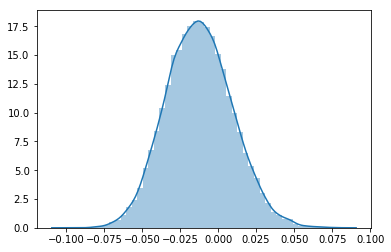

In [52]:
sns.distplot(all_mi)

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


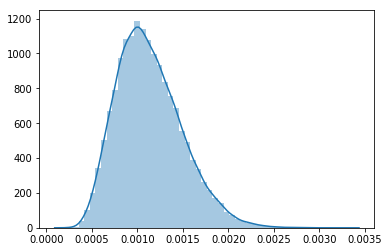

In [98]:
sns.distplot(all_hsic_norm)

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


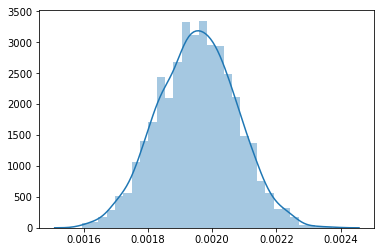

In [99]:
sns.distplot(all_hsic_loc)

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


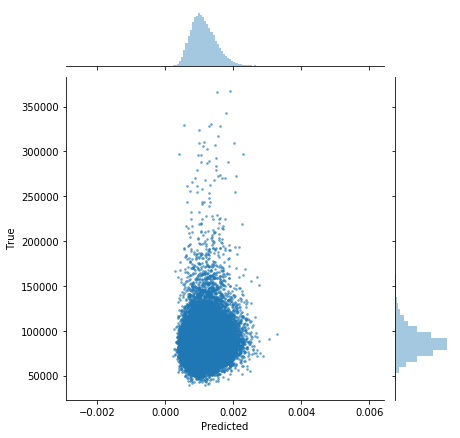

In [58]:
jointplot(all_hsic_norm, labels)

In [101]:
np.corrcoef(all_hsic_norm[top_idx], labels[top_idx])

array([[1.        , 0.53588405],
       [0.53588405, 1.        ]])

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


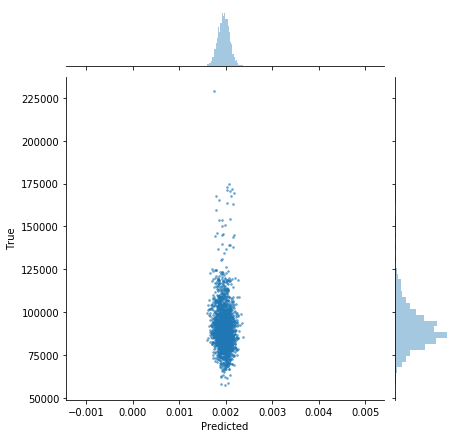

In [102]:
jointplot(all_hsic_loc, labels[:2000])

In [103]:
np.corrcoef(all_hsic_loc, labels[:2000])

array([[ 1.        , -0.07985085],
       [-0.07985085,  1.        ]])

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


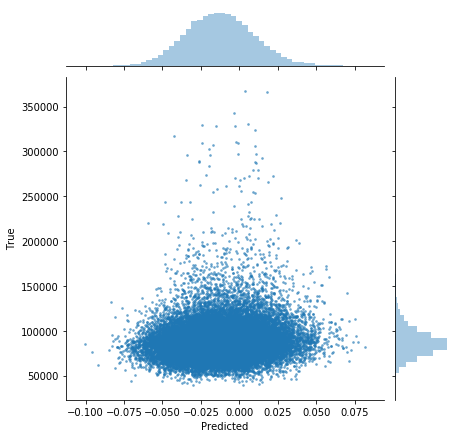

In [60]:
jointplot(all_mi, labels)

In [94]:
np.corrcoef(all_mi[top_idx], labels[top_idx])

array([[1.        , 0.50952892],
       [0.50952892, 1.        ]])

/cluster/sj1/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


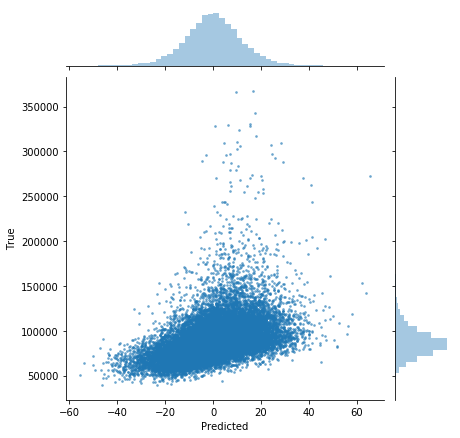

In [62]:
jointplot(preds_norm.sum(0), labels)

In [56]:
sort_idx = labels.argsort()

In [92]:
top_idx = sort_idx[-10:]

In [93]:
np.corrcoef(preds_norm.sum(0)[top_idx], labels[top_idx])

array([[1.        , 0.13859504],
       [0.13859504, 1.        ]])